En este notebook se entrena un agente Deep Q-Network (DQN) usando la librería TF-Agents para resolver el entorno MountainCar-v0 de OpenAI Gym.

MountainCar es un entorno clásico de control donde el objetivo es que un carro atrapado en un valle genere impulso moviéndose hacia atrás y adelante hasta alcanzar la cima.

# Librerias
Instalamos dependencias necesarias y configuramos librerías para renderizar video dentro del notebook.

In [30]:
from IPython.display import clear_output
!sudo apt-get update
!sudo apt-get install -y xvfb ffmpeg freeglut3-dev
!pip install 'imageio==2.4.0'
!pip install pyvirtualdisplay
!pip install tf-agents[reverb]
!pip install pyglet
clear_output()

In [31]:
from __future__ import absolute_import, division, print_function
import warnings
import base64
import imageio
import IPython
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image
import pyvirtualdisplay
import reverb
import tensorflow as tf

from tf_agents.agents.dqn import dqn_agent
from tf_agents.drivers import py_driver
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import sequential
from tf_agents.policies import py_tf_eager_policy
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import reverb_replay_buffer
from tf_agents.replay_buffers import reverb_utils
from tf_agents.trajectories import trajectory
from tf_agents.specs import tensor_spec
from tf_agents.utils import common
warnings.filterwarnings('ignore')
clear_output()

In [32]:
# Set up a virtual display for rendering OpenAI gym environments.
display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()

In [33]:
tf.version.VERSION

'2.15.1'

# Hyperparameters
Se definen los parámetros principales del entrenamiento:

* `num_iterations`: cantidad total de pasos de entrenamiento.
* `initial_collect_steps`: cuántos pasos recolectar aleatoriamente antes de entrenar.
* `collect_steps_per_iteration`: cuántos pasos usar por iteración para recolectar experiencia.
* `replay_buffer_max_length`: tamaño máximo del buffer de Replay.
* `batch_size`: tamaño de muestras usadas en cada actualización del Q-network.
* `learning_rate`: tasa de aprendizaje del optimizador Adam.
* `log_interval`: cada cuántos pasos imprimir la pérdida.
* `num_eval_episodes`: episodios usados en cada evaluación.
* `eval_interval`: cada cuántos pasos evaluar el agente.

In [34]:
num_iterations = 50000 # @param {type:"integer"}
initial_collect_steps = 1000  # @param {type:"integer"}
collect_steps_per_iteration = 1 # @param {type:"integer"}
replay_buffer_max_length = 100000  # @param {type:"integer"}

batch_size = 64  # @param {type:"integer"}
learning_rate = 1e-3  # @param {type:"number"}
log_interval = 1000  # @param {type:"integer"}
num_eval_episodes = 10  # @param {type:"integer"}
eval_interval = 5000  # @param {type:"integer"}

# Environment

Se carga el entorno MountainCar-v0 y se visualiza su estado inicial.

El entorno provee:

+ Estado: `[posición, velocidad]`
+ Acciones:
    * 0: empujar a la izquierda
    * 1: no hacer nada
    * 2: empujar a la derecha
+ Recompensa:
    * -1 en cada paso
    * 0 si el carro llega a la cima

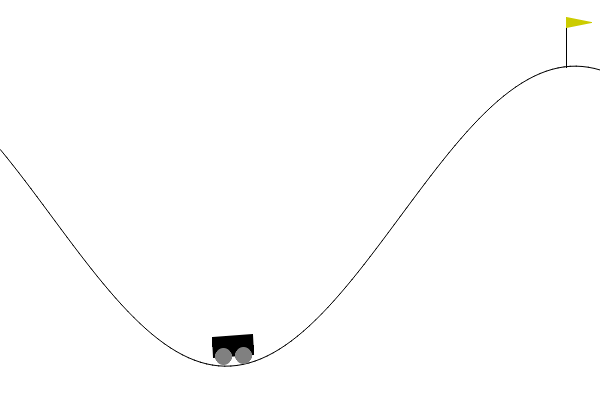

In [35]:
env_name = 'MountainCar-v0'
env = suite_gym.load(env_name)
env.reset()
PIL.Image.fromarray(env.render())

In [36]:
print("\nObservation Spec:", env.time_step_spec().observation)
print("\nReward Spec:", env.time_step_spec().reward)
print("\nAction Spec:", env.action_spec())
time_step = env.reset(); print('\nTime step:', time_step)


Observation Spec: BoundedArraySpec(shape=(2,), dtype=dtype('float32'), name='observation', minimum=[-1.2  -0.07], maximum=[0.6  0.07])

Reward Spec: ArraySpec(shape=(), dtype=dtype('float32'), name='reward')

Action Spec: BoundedArraySpec(shape=(), dtype=dtype('int64'), name='action', minimum=0, maximum=2)

Time step: TimeStep(
{'step_type': array(0, dtype=int32),
 'reward': array(0., dtype=float32),
 'discount': array(1., dtype=float32),
 'observation': array([-0.5388694,  0.       ], dtype=float32)})


In [37]:
action = np.array(1, dtype=np.int32); next_time_step = env.step(action)
print('Next time step:'); print(next_time_step)

Next time step:
TimeStep(
{'step_type': array(1, dtype=int32),
 'reward': array(-1., dtype=float32),
 'discount': array(1., dtype=float32),
 'observation': array([-5.3875494e-01,  1.1448963e-04], dtype=float32)})


El entorno entrega:

-   `observation` is an array of 2 floats: 
    -   the position of the car along the x-axis
    -   the velocity of the car 
-   `reward` is a scalar float value (-1 for step)
-   `action` is a scalar integer with only three possible values:
    -   `0` — "Accelerate to the left"
    -   `1` — "Don't accelerate"
    -   `2` - "Accelerate to the right"


In [38]:
train_py_env = suite_gym.load(env_name)
eval_py_env = suite_gym.load(env_name)

train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

# Agent (DQN)

Se crea el agente DQN, compuesto por:

**1. Q-Network**

Una red neuronal densa que aproxima la función Q(s, a).
Tiene configurable:
* número de capas
* tamaño de cada capa
* función de activación (ReLU)

El Q-network recibe el estado `[posición, velocidad]` y produce un valor Q para cada acción.

**2. Optimizador**

Se utilizó Adam, recomendado para RL por su estabilidad.

**3. Configuración del agente**

Se define:

+ `epsilon_greedy`: probabilidad de tomar acciones aleatorias.
+ `gamma`: factor de descuento.
+ `td_errors_loss_fn`: pérdida usada por DQN (MSE).
+ `train_step_counter`: contador de pasos para sincronizar con TF-Agents.

In [39]:
fc_layer_params = (64, 64)

action_tensor_spec = tensor_spec.from_spec(env.action_spec())
num_actions = action_tensor_spec.maximum - action_tensor_spec.minimum + 1

def dense_layer(num_units):
    return tf.keras.layers.Dense(
        num_units,
        activation=tf.keras.activations.relu,
        kernel_initializer=tf.keras.initializers.VarianceScaling(
            scale=2.0, mode='fan_in', distribution='truncated_normal'))
    
dense_layers = [dense_layer(num_units) for num_units in fc_layer_params]

q_values_layer = tf.keras.layers.Dense(
    num_actions,
    activation=None,
    kernel_initializer=tf.keras.initializers.RandomUniform(
        minval=-0.03, maxval=0.03),
    bias_initializer=tf.keras.initializers.Constant(-0.2))

q_net = sequential.Sequential(dense_layers + [q_values_layer])

In [40]:
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

train_step_counter = tf.Variable(0)

agent = dqn_agent.DqnAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    q_network=q_net,
    optimizer=optimizer,
    epsilon_greedy=0.1,    # <- mejora exploración
    gamma=0.99,            # <- recomendado
    td_errors_loss_fn=common.element_wise_squared_loss,
    train_step_counter=train_step_counter)

agent.initialize()

# Policies

Se crea:

+ Política de evaluación (`agent.policy`): Se usa para medir desempeño sin exploración extra.

+ Política de recolección (`agent.collect_policy`): Se usa para generar experiencia mientras el agente se entrena.

+ Política aleatoria (`random_policy`): Se usa para llenar el buffer antes de entrenar y para comparar desempeño.

In [41]:
eval_policy = agent.policy
collect_policy = agent.collect_policy
random_policy = random_tf_policy.RandomTFPolicy(train_env.time_step_spec(),
                                                train_env.action_spec())

In [42]:
example_environment = tf_py_environment.TFPyEnvironment(
    suite_gym.load('MountainCar-v0'))

In [43]:
time_step = example_environment.reset()
random_policy.action(time_step)

PolicyStep(action=<tf.Tensor: shape=(1,), dtype=int64, numpy=array([1])>, state=(), info=())

# Metrics and Evaluation

Se define la función `compute_avg_return()` que evalúa la política durante varios episodios y calcula la recompensa promedio. Esto sirve para monitorear el progreso del agente durante el entrenamiento.

La evaluación se hace “en limpio”, sin recolección ni perturbaciones, lo cual nos da una medida estable del desempeño real del agente.


In [44]:
def compute_avg_return(environment, policy, num_episodes=10):
    total_return = 0.0

    for _ in range(num_episodes):
        time_step = environment.reset()
        episode_return = 0.0

        while not time_step.is_last():
            action_step = policy.action(time_step)
            time_step = environment.step(action_step.action)
            episode_return += time_step.reward

        total_return += episode_return

    avg_return = total_return / num_episodes
    return avg_return.numpy()[0]
    
compute_avg_return(eval_env, random_policy, num_eval_episodes)

-200.0

# Replay Buffer

Para hacer seguimiento de los datos recolectados del entorno, se utiliza Reverb, un sistema de replay eficiente, extensible y fácil de usar desarrollado por DeepMind.
Reverb almacena los datos de experiencia cuando recopilamos trayectorias y dichos datos son consumidos durante el entrenamiento.

Este replay buffer se construye usando specs que describen los tensores que deben almacenarse, los cuales pueden obtenerse del agente mediante `agent.collect_data_spec`.


In [45]:
table_name = 'uniform_table'
replay_buffer_signature = tensor_spec.from_spec(agent.collect_data_spec)
replay_buffer_signature = tensor_spec.add_outer_dim(replay_buffer_signature)

table = reverb.Table(
    table_name,
    max_size=replay_buffer_max_length,
    sampler=reverb.selectors.Uniform(),
    remover=reverb.selectors.Fifo(),
    rate_limiter=reverb.rate_limiters.MinSize(1),
    signature=replay_buffer_signature)

reverb_server = reverb.Server([table])

replay_buffer = reverb_replay_buffer.ReverbReplayBuffer(
    agent.collect_data_spec,
    table_name=table_name,
    sequence_length=2,
    local_server=reverb_server)

rb_observer = reverb_utils.ReverbAddTrajectoryObserver(
    replay_buffer.py_client,
    table_name,
    sequence_length=2)

agent.collect_data_spec
agent.collect_data_spec._fields
clear_output()

# Data Collection

Antes de entrenar, se recolectan episodios usando la política aleatoria. Esto evita que el agente inicialice el buffer con experiencias sesgadas o triviales.

Luego se crea el dataset del buffer:
+ Se crea un generador de muestras.
+ Permite extraer batch_size transiciones continuamente.
+ Es eficiente gracias a `prefetch()`.

In [46]:
# Recolección Inicial
py_driver.PyDriver(
    env,
    py_tf_eager_policy.PyTFEagerPolicy(
        random_policy, use_tf_function=True),
    [rb_observer],
    max_steps=initial_collect_steps).run(train_py_env.reset())

(TimeStep(
 {'step_type': array(1, dtype=int32),
  'reward': array(-1., dtype=float32),
  'discount': array(1., dtype=float32),
  'observation': array([-0.52623236, -0.00098766], dtype=float32)}),
 ())

In [47]:
# Dataset del replay buffer
dataset = replay_buffer.as_dataset(
    num_parallel_calls=3,
    sample_batch_size=batch_size,
    num_steps=2).prefetch(3)

dataset_iterator = iter(dataset)

print(dataset_iterator)

# Training the agent

Aquí se encuentra el ciclo principal de RL:
1. Se ejecuta un paso en el entorno usando `collect_policy`.
2. Se registra la transición en el buffer.
3. Se extrae un batch del buffer.
4. Se realiza una actualización de la red Q (gradient descent).
5. Registro de pérdidas.
6. Cada `eval_interval` pasos se evalua el desempeño.
7. Se guarda el retorno promedio en returns.

El ciclo continúa hasta completar `num_iterations`.

Incluye impresiones periódicas para seguir el progreso:
+ Pérdida de entrenamiento.
+ Retorno promedio.

In [48]:
try:
  %%time
except:
  pass

agent.train = common.function(agent.train)
agent.train_step_counter.assign(0)

avg_return = compute_avg_return(eval_env, agent.policy, num_eval_episodes)
returns = [avg_return]

time_step = train_py_env.reset()

collect_driver = py_driver.PyDriver(
    env,
    py_tf_eager_policy.PyTFEagerPolicy(
        agent.collect_policy, use_tf_function=True),
    [rb_observer],
    max_steps=collect_steps_per_iteration)

print("Entrenando...\n")

for _ in range(num_iterations):

    time_step, _ = collect_driver.run(time_step)

    experience, unused_info = next(dataset_iterator)
    train_loss = agent.train(experience).loss

    step = agent.train_step_counter.numpy()

    if step % log_interval == 0:
        print('step = {0}: loss = {1}'.format(step, train_loss))

    if step % eval_interval == 0:
        avg_return = compute_avg_return(
            eval_env, agent.policy, num_eval_episodes)
        print('step = {0}: Average Return = {1}'.format(step, avg_return))
        returns.append(avg_return)

Entrenando...



[reverb/cc/client.cc:165] Sampler and server are owned by the same process (8727) so Table uniform_table is accessed directly without gRPC.
[reverb/cc/client.cc:165] Sampler and server are owned by the same process (8727) so Table uniform_table is accessed directly without gRPC.
[reverb/cc/client.cc:165] Sampler and server are owned by the same process (8727) so Table uniform_table is accessed directly without gRPC.
[reverb/cc/client.cc:165] Sampler and server are owned by the same process (8727) so Table uniform_table is accessed directly without gRPC.
[reverb/cc/client.cc:165] Sampler and server are owned by the same process (8727) so Table uniform_table is accessed directly without gRPC.
[reverb/cc/client.cc:165] Sampler and server are owned by the same process (8727) so Table uniform_table is accessed directly without gRPC.


step = 1000: loss = 0.38652142882347107
step = 2000: loss = 0.6876004338264465
step = 3000: loss = 0.468587189912796
step = 4000: loss = 0.38376158475875854
step = 5000: loss = 63.69688415527344
step = 5000: Average Return = -200.0
step = 6000: loss = 0.35323941707611084
step = 7000: loss = 0.2805964946746826
step = 8000: loss = 0.34293657541275024
step = 9000: loss = 0.35750454664230347
step = 10000: loss = 0.6534889936447144
step = 10000: Average Return = -200.0
step = 11000: loss = 0.45512592792510986
step = 12000: loss = 14.940530776977539
step = 13000: loss = 20.895431518554688
step = 14000: loss = 35.275142669677734
step = 15000: loss = 0.22149989008903503
step = 15000: Average Return = -200.0
step = 16000: loss = 0.24211743474006653
step = 17000: loss = 0.24158833920955658
step = 18000: loss = 0.30501049757003784
step = 19000: loss = 44.18971633911133
step = 20000: loss = 0.39446812868118286
step = 20000: Average Return = -200.0
step = 21000: loss = 0.29297110438346863
step = 22

# Visualization

Finalmente, se genera:

+ **Gráfico de Retorno Promedio**: Muestra cómo mejora el desempeño a medida que entrena.

+ **Creación de Videos**

Funciones que:
1. Ejecutan la política entrenada.
2. Capturan fotogramas.
3. Buscan representar visualmente la calidad del comportamiento.
4. Incrustan videos en el notebook para fácil análisis.

También se muestra un video comparativo con una política aleatoria.

Esto permite observar si el agente:
+ Sube correctamente el valle.
+ Obtiene suficiente impulso hacia atrás.
+ Ejecuta secuencias de acciones coherentes para resolver la tarea.

### Plot (Gráfica de Retorno Promedio)

Text(0.5, 0, 'Iterations')

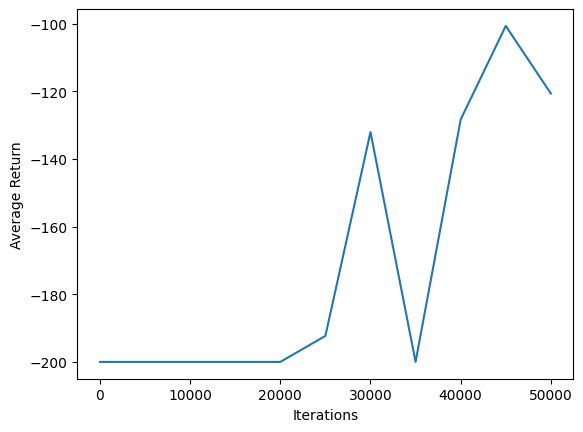

In [53]:
iterations = range(0, num_iterations + 1, eval_interval)
plt.plot(iterations, returns)
plt.ylabel('Average Return')
plt.xlabel('Iterations')

### Videos

In [50]:
def embed_mp4(filename):
  """Embeds an mp4 file in the notebook."""
  video = open(filename,'rb').read()
  b64 = base64.b64encode(video)
  tag = '''
  <video width="640" height="480" controls>
    <source src="data:video/mp4;base64,{0}" type="video/mp4">
  Your browser does not support the video tag.
  </video>'''.format(b64.decode())

  return IPython.display.HTML(tag)

In [51]:
def create_policy_eval_video(policy, filename, num_episodes=5, fps=30):
  filename = filename + ".mp4"
  with imageio.get_writer(filename, fps=fps) as video:
    for _ in range(num_episodes):
      time_step = eval_env.reset()
      video.append_data(eval_py_env.render())
      while not time_step.is_last():
        action_step = policy.action(time_step)
        time_step = eval_env.step(action_step.action)
        video.append_data(eval_py_env.render())
  return embed_mp4(filename)

create_policy_eval_video(agent.policy, "trained-agent")

[swscaler @ 0x5c5dbc629a40] Warning: data is not aligned! This can lead to a speed loss


In [52]:
create_policy_eval_video(random_policy, "random-agent")

[swscaler @ 0x593df8467a40] Warning: data is not aligned! This can lead to a speed loss
